In [1]:
# Computations
import numpy as np
import pandas as pd
import squarify

# Text Colors
from colorama import Fore, Back, Style

# datetime
from datetime import datetime, timedelta

# Plots

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon

# sns setting
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":14,"axes.labelsize":12})
sns.set_style("whitegrid")

# plt setting
plt.style.use('seaborn-whitegrid')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# E-Commerce Data

In this study, we chose a dataset from [Kaggle.com](https://www.kaggle.com). The dataset can be found [here](https://www.kaggle.com/carrie1/ecommerce-data). Description based on [Kaggle.com](https://www.kaggle.com):

**Context**

Typically e-commerce datasets are proprietary and consequently hard to find among publicly available data. However, The UCI Machine Learning Repository has made this dataset containing actual transactions from 2010 and 2011. The dataset is maintained on their site, where it can be found by the title "Online Retail".

**Content**

"This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers."

## Dataset

In [2]:
def Data_info(Inp):
    Out = pd.DataFrame(Inp.dtypes,columns=['Data Type']).sort_values(by=['Data Type'])
    Out = Out.join(pd.DataFrame(Inp.isnull().sum(), columns=['Number of NaN Values']), how='outer')
    Out['Percentage'] = np.round(100*(Out['Number of NaN Values']/Inp.shape[0]),2)
    return Out

In [3]:
Data = pd.read_csv('Data/data.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
display(Data.head())
display(Data_info(Data).T)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


,Country,CustomerID,Description,InvoiceDate,InvoiceNo,Quantity,StockCode,UnitPrice
Data Type,object,object,object,object,object,int64,object,float64
Number of NaN Values,0,135080,1454,0,0,0,0,0
Percentage,0,24.93,0.27,0,0,0,0,0


Droping NaN Values

In [4]:
Data.dropna(inplace = True)

Converting some columns

In [5]:
Data['InvoiceDate'] = pd.to_datetime(Data['InvoiceDate'])

Removing duplicated entries:

In [6]:
print('Number of Duplicated Entries = %i' % Data.duplicated().sum())
Data.drop_duplicates(inplace = True)

Number of Duplicated Entries = 5225


In [7]:
print(Back.CYAN +'Data size: %i rows and %i columns' % Data.shape)
print(Back.MAGENTA +'Timeline: From %s till %s' % (Data['InvoiceDate'].min(), Data['InvoiceDate'].max()))

Data size: 401604 rows and 8 columns
Timeline: From 2010-12-01 08:26:00 till 2011-12-09 12:50:00


## Recency, Frequency, Monetary (RFM) Scoring

Let's create some new features.

| Feature        | Description                                                                    |
|----------------|--------------------------------------------------------------------------------|
| Total_Spending | Total amount of spending                                                       |
| Recency        | Days since the last purchase                                                   |
| Frequency      | Transactions numbers over a defined period                                     |
| Monetary       | Total spending over a defined period                                           |
| RFM Group      | Assigning a customer to an RFM group based on their recency, frequency, monetary |

Customers here are divided into several groups based on their recency, frequency, monetary.

In [8]:
# Total Spending
Data['Total_Spending'] = Data['Quantity'] * Data['UnitPrice']

# Recency
LastDay = Data['InvoiceDate'].max() + timedelta(days=1)
Temp0 = pd.DataFrame(Data.groupby(['CustomerID'])['InvoiceDate'].max())
Temp0.columns = ['Recency']
Temp0 = Temp0.reset_index(drop = False)
Temp0.iloc[:,1] = Temp0.iloc[:,1].apply(lambda x: (Data['InvoiceDate'].max() + timedelta(days=1) - x).days)

# Frequency
Temp1 = pd.DataFrame(Data.groupby(['CustomerID'])['InvoiceDate'].count())
Temp1.columns = ['Frequency']
Temp1 = Temp1.reset_index(drop = False)

# Monetary
Temp2 = pd.DataFrame(Data.groupby(['CustomerID'])['Total_Spending'].sum())
Temp2.columns = ['Monetary']
Temp2 = Temp2.reset_index(drop = False)

# Merging
df = Temp0.merge(Temp1, left_on='CustomerID', right_on='CustomerID')
df = df.merge(Temp2, left_on='CustomerID', right_on='CustomerID')
del Temp0, Temp1, Temp2

# RFM Groups
df['R'] = pd.qcut(df['Recency'], q=4, labels=np.arange(4, 0, -1))
df['F'] = pd.qcut(df['Frequency'], q=4, labels=np.arange(1, 5, 1))
df['M'] = pd.qcut(df['Monetary'], q=4, labels=np.arange(1, 5, 1))
def RFM_df(x):
    return 'R' + str(x['R']) + 'F' + str(x['F']) +  'M' + str(x['M'])
df['RFM_Group'] = df.apply(RFM_df, axis=1)
display(df.head().style.hide_index())

CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Group
12346,326,2,0.000000,1,1,1,R1F1M1
12347,2,182,4310.000000,4,4,4,R4F4M4
12348,75,31,1797.240000,2,2,4,R2F2M4
12349,19,73,1757.550000,3,3,4,R3F3M4
12350,310,17,334.400000,1,1,2,R1F1M2


A representation of the distribution of data can be found using [pandas hist function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html):

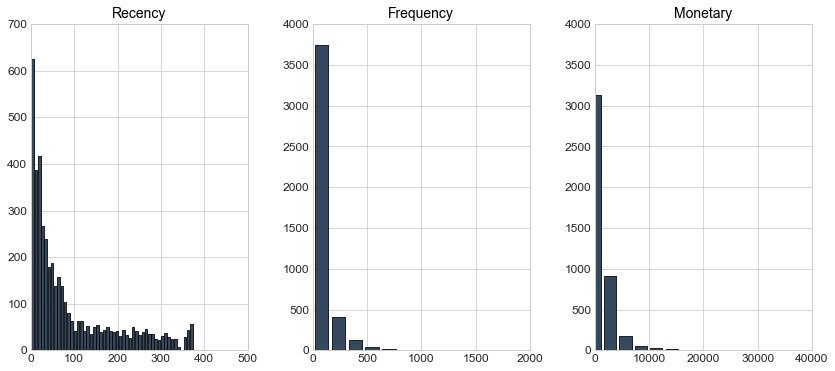

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(14, 6), sharex = False)
_ = df.hist(ax = ax[0], bins=50, column= df.columns.tolist()[1],
               grid=True, sharex=False, layout=(1,3), figsize=(18,4), color='#34495e', edgecolor='k',
               backend=None, zorder=2, rwidth=0.8)
_ = ax[0].set_xlim([0,5e2])
_ = ax[0].set_ylim([0,7e2])

_ = df.hist(ax = ax[1], bins=50, column= df.columns.tolist()[2],
               grid=True, sharex=False, layout=(1,3), figsize=(18,4), color='#34495e', edgecolor='k',
               backend=None, zorder=2, rwidth=0.8)
_ = ax[1].set_xlim([0,2e3])
_ = ax[1].set_ylim([0,4e3])

_ = df.hist(ax = ax[2], bins=100, column= df.columns.tolist()[3],
               grid=True, sharex=False, layout=(1,3), figsize=(18,4), color='#34495e', edgecolor='k',
               backend=None, zorder=2, rwidth=0.8)
_ = ax[2].set_xlim([0,4e4])
_ = ax[2].set_ylim([0,4e3])

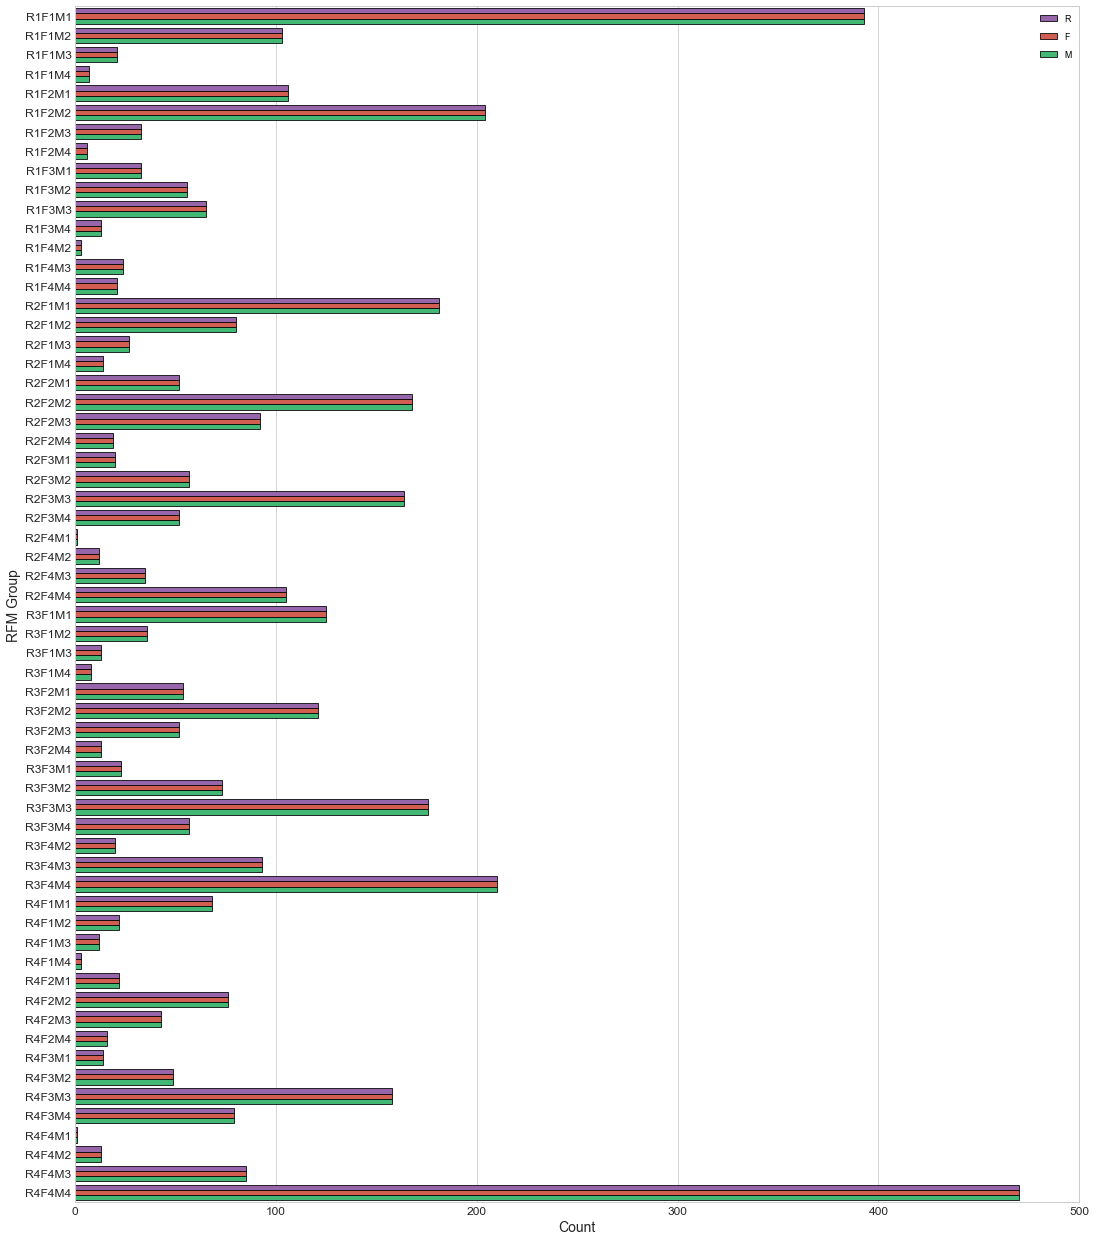

In [10]:
Group = df.groupby('RFM_Group')[['R','F','M']].count().reset_index(drop = False)
Group = pd.melt(Group, id_vars=['RFM_Group'], value_vars=['R','F','M'], var_name='RFM', value_name='Count')

fig, ax = plt.subplots(1, 1, figsize=(18, 22), sharex=True)
_ = sns.barplot(y="RFM_Group", x="Count", hue="RFM", data=Group, ax = ax,
                palette = sns.color_palette(["#9b59b6","#e74c3c", "#2ecc71"]), edgecolor='k')
_ = ax.set_xlim([0,500])
_ = ax.set_xlabel('Count')
_ = ax.set_ylabel('RFM Group')
_ = ax.legend(scatterpoints=1, frameon=False, labelspacing=1, title='')

## Calculating RFM Scores

In [11]:
df['RFM_Score'] = df[['R','F','M']].sum(axis=1).astype(int)
df['RFM_Level'] = df['RFM_Score'].apply(lambda x: x - df['RFM_Score'].min() + 1)
display(df.head().style.hide_index())

CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Group,RFM_Score,RFM_Level
12346,326,2,0.000000,1,1,1,R1F1M1,3,1
12347,2,182,4310.000000,4,4,4,R4F4M4,12,10
12348,75,31,1797.240000,2,2,4,R2F2M4,8,6
12349,19,73,1757.550000,3,3,4,R3F3M4,10,8
12350,310,17,334.400000,1,1,2,R1F1M2,4,2


,RFM_Level,Count,Recency,Frequency,Monetary
0,1,393,264.75,7.85,109.25
1,2,390,174.88,13.79,226.57
2,3,515,152.50,20.92,342.69
3,4,469,94.59,28.11,490.78
4,5,439,79.49,39.22,722.68
5,6,467,62.76,56.08,965.48
6,7,413,44.37,77.38,1341.58
7,8,442,31.52,112.60,1819.21
8,9,374,20.47,190.42,3892.08
9,10,470,6.71,367.72,8848.13


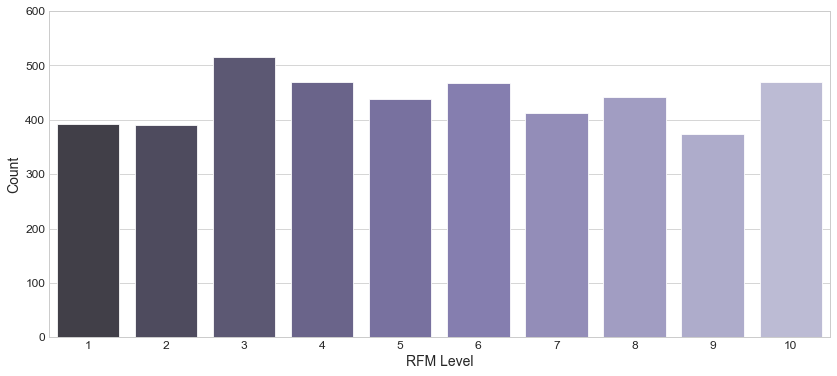

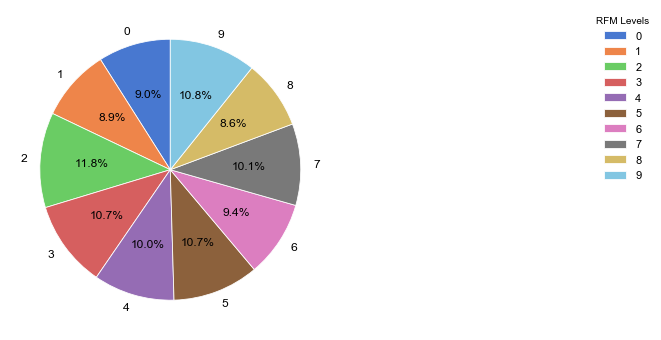

In [12]:
Group = pd.DataFrame(df.groupby('RFM_Level')['CustomerID'].count())
Group.columns = ['Count']
Group = Group.reset_index(drop = False)
Group = Group.sort_values(by=['RFM_Level'])
Group1 = df.groupby(['RFM_Level'])[['Recency', 'Frequency', 'Monetary']].mean().round(2).reset_index()
Group = Group.merge(Group1, on='RFM_Level')
display(Group)

del Group1
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 6), sharex = True)
_ = sns.barplot(x="RFM_Level", y="Count", palette="Purples_d", data = Group, ax = ax)
_ = ax.set_ylim([0,600])
_ = ax.set_xlabel('RFM Level')

fig, ax = plt.subplots(1,1, figsize=(6,6))
_ = Group.plot.pie(y='Count', startangle=90, legend=False,label='',ax=ax, autopct='%1.1f%%',
                   colors = sns.color_palette("muted", len(Group)), fontsize=12)
_ = ax.legend(bbox_to_anchor=(2, 1), fontsize=11, title='RFM Levels')

***